In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np 
import matplotlib.pyplot as plt  
%matplotlib inline

torch.manual_seed(1337)

## Hyperparameters & Data Loading

In [2]:
lr = 1e-4
gamma = 0.1
step_size = 10
num_epochs = 30
batch_size = 100

input_dim = 784
hidden_dim = 250
k = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: torch.flatten(x)) # flattens to [784,]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## RBM Helper Functions

In [4]:
def sample_bernoulli(h):
    ''' Samples from a Bernoulli distribution for hidden layer units defined by h
    https://pytorch.org/docs/stable/generated/torch.bernoulli.html
    
    Parameters:
        h (Tensor) [batch_size, hidden_dim] : hidden layer w/ each element = activation prob.
    
    Returns:
        the hidden layer w/ each element = activation prob. ~ Bernoulli dist.
        the ith element of the hidden layer will have value=1 according to the ith prob of h
    '''
    return torch.bernoulli(h)

def sample_gaussian(x):
    ''' Samples from a Gaussian distribution for visible layer units defined by x
    
    Parameters:
        x (Tensor) [batch_size, input_dim] : visible layer w/ each element = activation prob.
    
    Returns:
        the visible layer w/ each element = activation prob. ~ Gaussian dist.
    '''
    epsilon = torch.randn(x.size()).to(x.device)
    return x + epsilon

## RBM Model Architecture

In [5]:
class RBM(nn.Module):
    '''
    Bernoulli-Bernoulli RBM architecture for MNIST image generation/sampling
    
    After k steps of persistent contrastive divergence, the weights and biases define the joint prob. 
    dist. over the visible and hidden units that ideally mimics the data dist. Whole idea is to use
    CD-k to reduce energy of data samples (more likely under the model) and increase energy of
    generated samples (less likely under the model).
    
    To sample, we pass Gaussian noise into the Gibbs sampling to shape the noise according to the
    learned weights and biases that define the model distribution. Ideally at the end, we end up
    with a sample that looks like one from the data distribution if model dist ~ data dist
    
    by Elliot H Ha
    '''
    def __init__(self, input_dim, hidden_dim, k):
        '''
        Parameters:
            input_dim (int)  : # of features for the visible layer
            hidden_dim (int) : # of features for the hidden layer
            k (int)          : # of contrastive divergence steps for MCMC (Gibbs sampling)
        '''
        super().__init__()
        
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim)*1e-2) # visible-hidden weights matrix; [input_dim, hidden_dim] 
        self.c = nn.Parameter(torch.zeros(input_dim))  # visible unit biases; [input_dim]
        self.b = nn.Parameter(torch.zeros(hidden_dim)) # hidden unit biases; [hidden_dim]
        
        self.k = k
    
    def forward(self, x):
        ''' The forward pass of the RBM = k steps of MCMC Gibbs sampling to get the reconstructed x
        
        Parameters:
            x (Tensor) [batch_size, input_dim] : training examples from MNIST
        
        Returns:
            x_negative (Tensor) [batch_size, input_dim] : negative sample used for CD training
            x (Tensor) [batch_size, input_dim] : x conditionally based on h, used for inference
        '''
        x_negative = x
        
        for step in range(self.k):
            h = self.prob_h_x(x_negative)
            h_negative = sample_bernoulli(h) # change depending on RBM type
            
            x = self.prob_x_h(h_negative)
            x_negative = sample_bernoulli(x) # change depending on RBM type
        
        return x_negative, x
    
    def prob_h_x(self, x):
        ''' Calculates the conditional prob. P(h|x) defining a Bernoulli dist., hence the sigmoid
        Parameters:
            x (Tensor) [batch_size, input_dim] : the visible layer
        
        Returns:
            h (Tensor) [batch_size, hidden_dim] : hidden layer defined by the prob. of each element being 1, given x
        '''
        h = torch.sigmoid(F.linear(x, self.W.t(), self.b))
        return h
    
    def prob_x_h(self, h):
        ''' Calculates the conditional prob. P(x|h) defining a Gaussian dist.
        Parameters:
            h (Tensor) [batch_size, hidden_dim] : the hidden layer
        
        Returns:
            x (Tensor) [batch_size,] : visible layer defined by the prob. of each element being 1, given h
        '''
        x = torch.sigmoid(F.linear(h, self.W, self.c))
        return x
    
    def calc_free_energy_bernoulli_bernoulli(self, x):
        vbias_term = torch.matmul(x, self.c.unsqueeze(1)).squeeze()

        wx_b = F.linear(x, self.W.t(), self.b)  # wx_b = xW + b
        hidden_term = torch.log(1 + torch.exp(wx_b)).sum(dim=1)

        free_energy = (-vbias_term - hidden_term).mean()  # Sum over visible units and mean over the batch
        return free_energy
        
        
    def calc_free_energy_gaussian_bernoulli(self, x):
        '''
        Parameters:
            x (Tensor) [batch_size, input_dim] : batched flattened MNIST image
        
        Returns:
            free_energy (int) : the mean free energy over the batched input
        '''
        visible_energy = (0.5 * (x - self.c)**2).sum(dim=1) # [batch_size, input_dim] -> [batch_size] when summed over dim=1  
        wx_b = F.linear(x, self.W.t(), self.b) # wx_b = xW^T + b, need to transpose W since F.linear transposes the weights again 
        # wx_b = [batch_size, input_dim] * [input_dim, hidden_dim] + [hidden_dim] = [batch_size, hidden_dim] 
        hidden_energy = F.softplus(wx_b).sum(dim=1) # [batch_size, hidden_dim] -> [batch_size] when summed over dim=1
        # need a softplus s.t. contributions to the hidden energy are non-negative
        free_energy = (visible_energy - hidden_energy).mean() # [batch_size].mean() -> scalar value for mean free energy over batch 
        return free_energy

## Sampling & Training Functions

In [6]:
def sample(model, epoch, num_samples, space=0.1, ncols=5):
    x = torch.randn((num_samples, input_dim)).to(device) # initial visible units ~ N(0, I)
    
    model.eval()
    with torch.no_grad():
        _, samples = model(x)
    
    nrows = int(num_samples / ncols)
    figsize = (15, 3*nrows)
    samples = samples.cpu().detach().numpy()
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=True, squeeze=True)   
    
    for ax, img in zip(axes.flatten(), samples):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.subplots_adjust(wspace=space, hspace=0)
    plt.suptitle(f'RBM Generated Samples after {epoch} Training epochs', y=1.005)
    plt.tight_layout(pad=0.5)
    plt.show()

In [7]:
def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs):
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for i, batch in enumerate(train_loader):
            x, _ = batch
            # x += torch.randn(x.size()) # add noise to ensure gaussian variability for normalized data
            x = x.to(device)
            
            optimizer.zero_grad()
            
            x_negative, _ = model(x)
            data_free_energy = model.calc_free_energy_bernoulli_bernoulli(x)
            sample_free_energy = model.calc_free_energy_bernoulli_bernoulli(x_negative.detach())
            loss = data_free_energy - sample_free_energy
            # print(f'Data: {data_free_energy}, Sample: {sample_free_energy}, Loss: {loss}')
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                # x += torch.randn(x.size())
                x = x.to(device)
                
                x_negative, _ = model(x)
                data_free_energy = model.calc_free_energy_bernoulli_bernoulli(x)
                sample_free_energy = model.calc_free_energy_bernoulli_bernoulli(x_negative.detach())
                loss = data_free_energy - sample_free_energy
                
                val_loss += loss.item()
                
        if epoch % 10 == 0:
            sample(model, epoch, num_samples=5)
        
        print(f"Epoch {epoch+1}, Training Loss: {(train_loss / len(train_loader)):.4f}, Validation Loss: {(val_loss / len(val_loader)):.4f}")
        training_losses.append((train_loss / len(train_loader)))
        validation_losses.append((val_loss / len(val_loader)))
        
        # scheduler.step()
    
    return training_losses, validation_losses

## Training Results

In [8]:
model = RBM(input_dim, hidden_dim, k)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

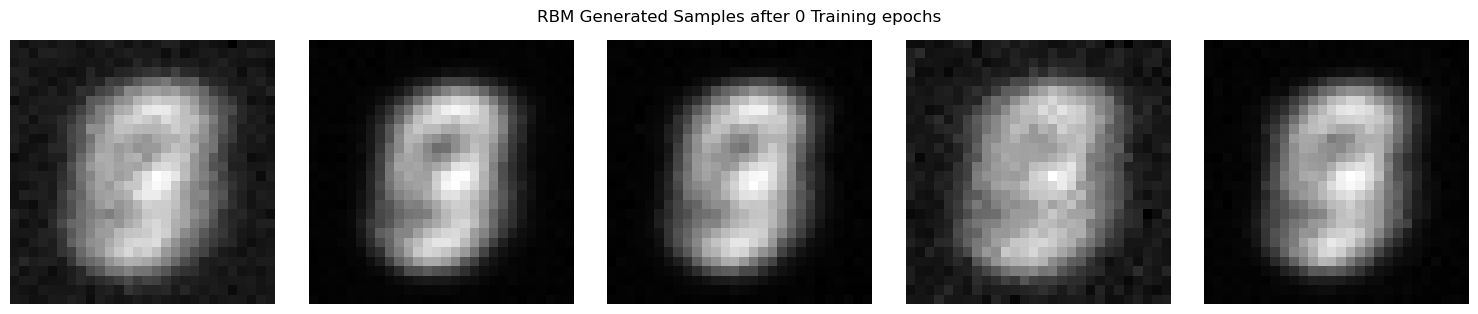

Epoch 1, Training Loss: -92.9018, Validation Loss: -68.3289
Epoch 2, Training Loss: -63.4056, Validation Loss: -59.8056
Epoch 3, Training Loss: -54.5180, Validation Loss: -49.2024
Epoch 4, Training Loss: -41.7911, Validation Loss: -36.4759
Epoch 5, Training Loss: -32.1288, Validation Loss: -29.9504
Epoch 6, Training Loss: -24.9780, Validation Loss: -22.2540
Epoch 7, Training Loss: -20.5851, Validation Loss: -19.9713
Epoch 8, Training Loss: -18.6195, Validation Loss: -17.8078
Epoch 9, Training Loss: -16.8565, Validation Loss: -15.7688
Epoch 10, Training Loss: -15.6507, Validation Loss: -15.7465


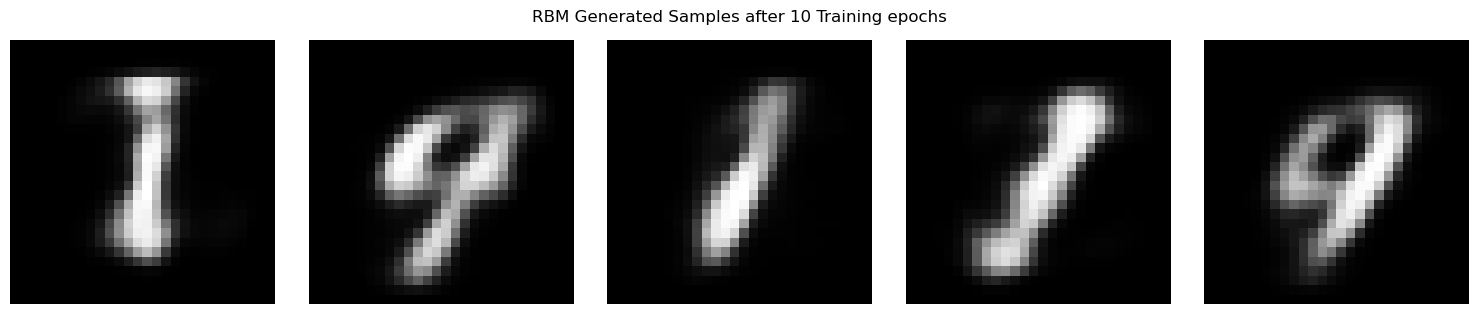

Epoch 11, Training Loss: -15.2700, Validation Loss: -15.6650
Epoch 12, Training Loss: -14.6552, Validation Loss: -14.6308
Epoch 13, Training Loss: -14.1641, Validation Loss: -13.8055
Epoch 14, Training Loss: -13.7744, Validation Loss: -13.9290
Epoch 15, Training Loss: -13.3589, Validation Loss: -13.6719
Epoch 16, Training Loss: -13.1164, Validation Loss: -13.6550
Epoch 17, Training Loss: -12.9040, Validation Loss: -12.7331
Epoch 18, Training Loss: -12.7883, Validation Loss: -13.1741
Epoch 19, Training Loss: -12.5907, Validation Loss: -13.1726
Epoch 20, Training Loss: -12.4848, Validation Loss: -12.7029


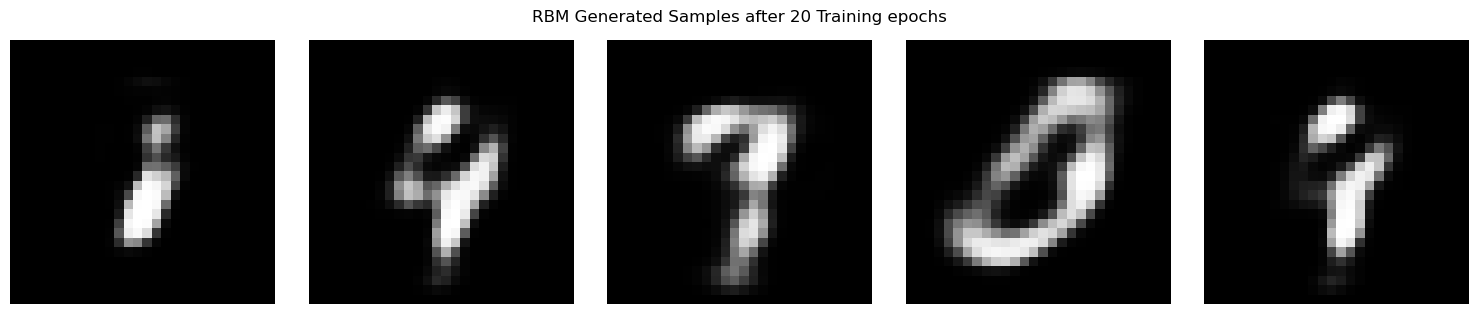

Epoch 21, Training Loss: -12.2549, Validation Loss: -12.9463
Epoch 22, Training Loss: -12.1710, Validation Loss: -12.5814
Epoch 23, Training Loss: -12.1094, Validation Loss: -12.3143
Epoch 24, Training Loss: -12.0089, Validation Loss: -12.5023
Epoch 25, Training Loss: -11.8594, Validation Loss: -12.0807
Epoch 26, Training Loss: -11.6788, Validation Loss: -12.2813
Epoch 27, Training Loss: -11.5999, Validation Loss: -11.6871
Epoch 28, Training Loss: -11.3842, Validation Loss: -11.8343
Epoch 29, Training Loss: -11.2996, Validation Loss: -11.8557
Epoch 30, Training Loss: -11.1780, Validation Loss: -11.1017


In [9]:
training_losses, validation_losses = train(model, train_loader, val_loader, optimizer, scheduler, num_epochs)

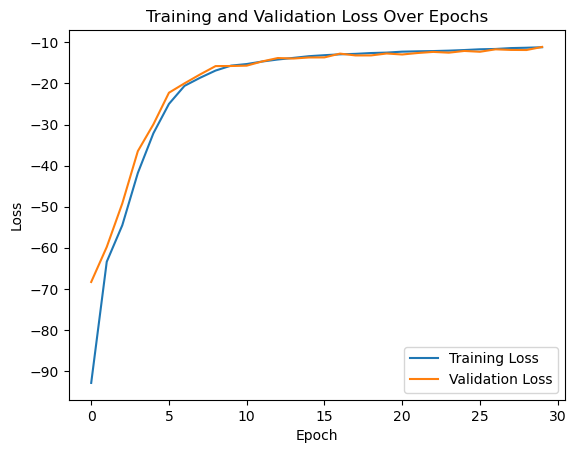

In [10]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Final RBM Samples

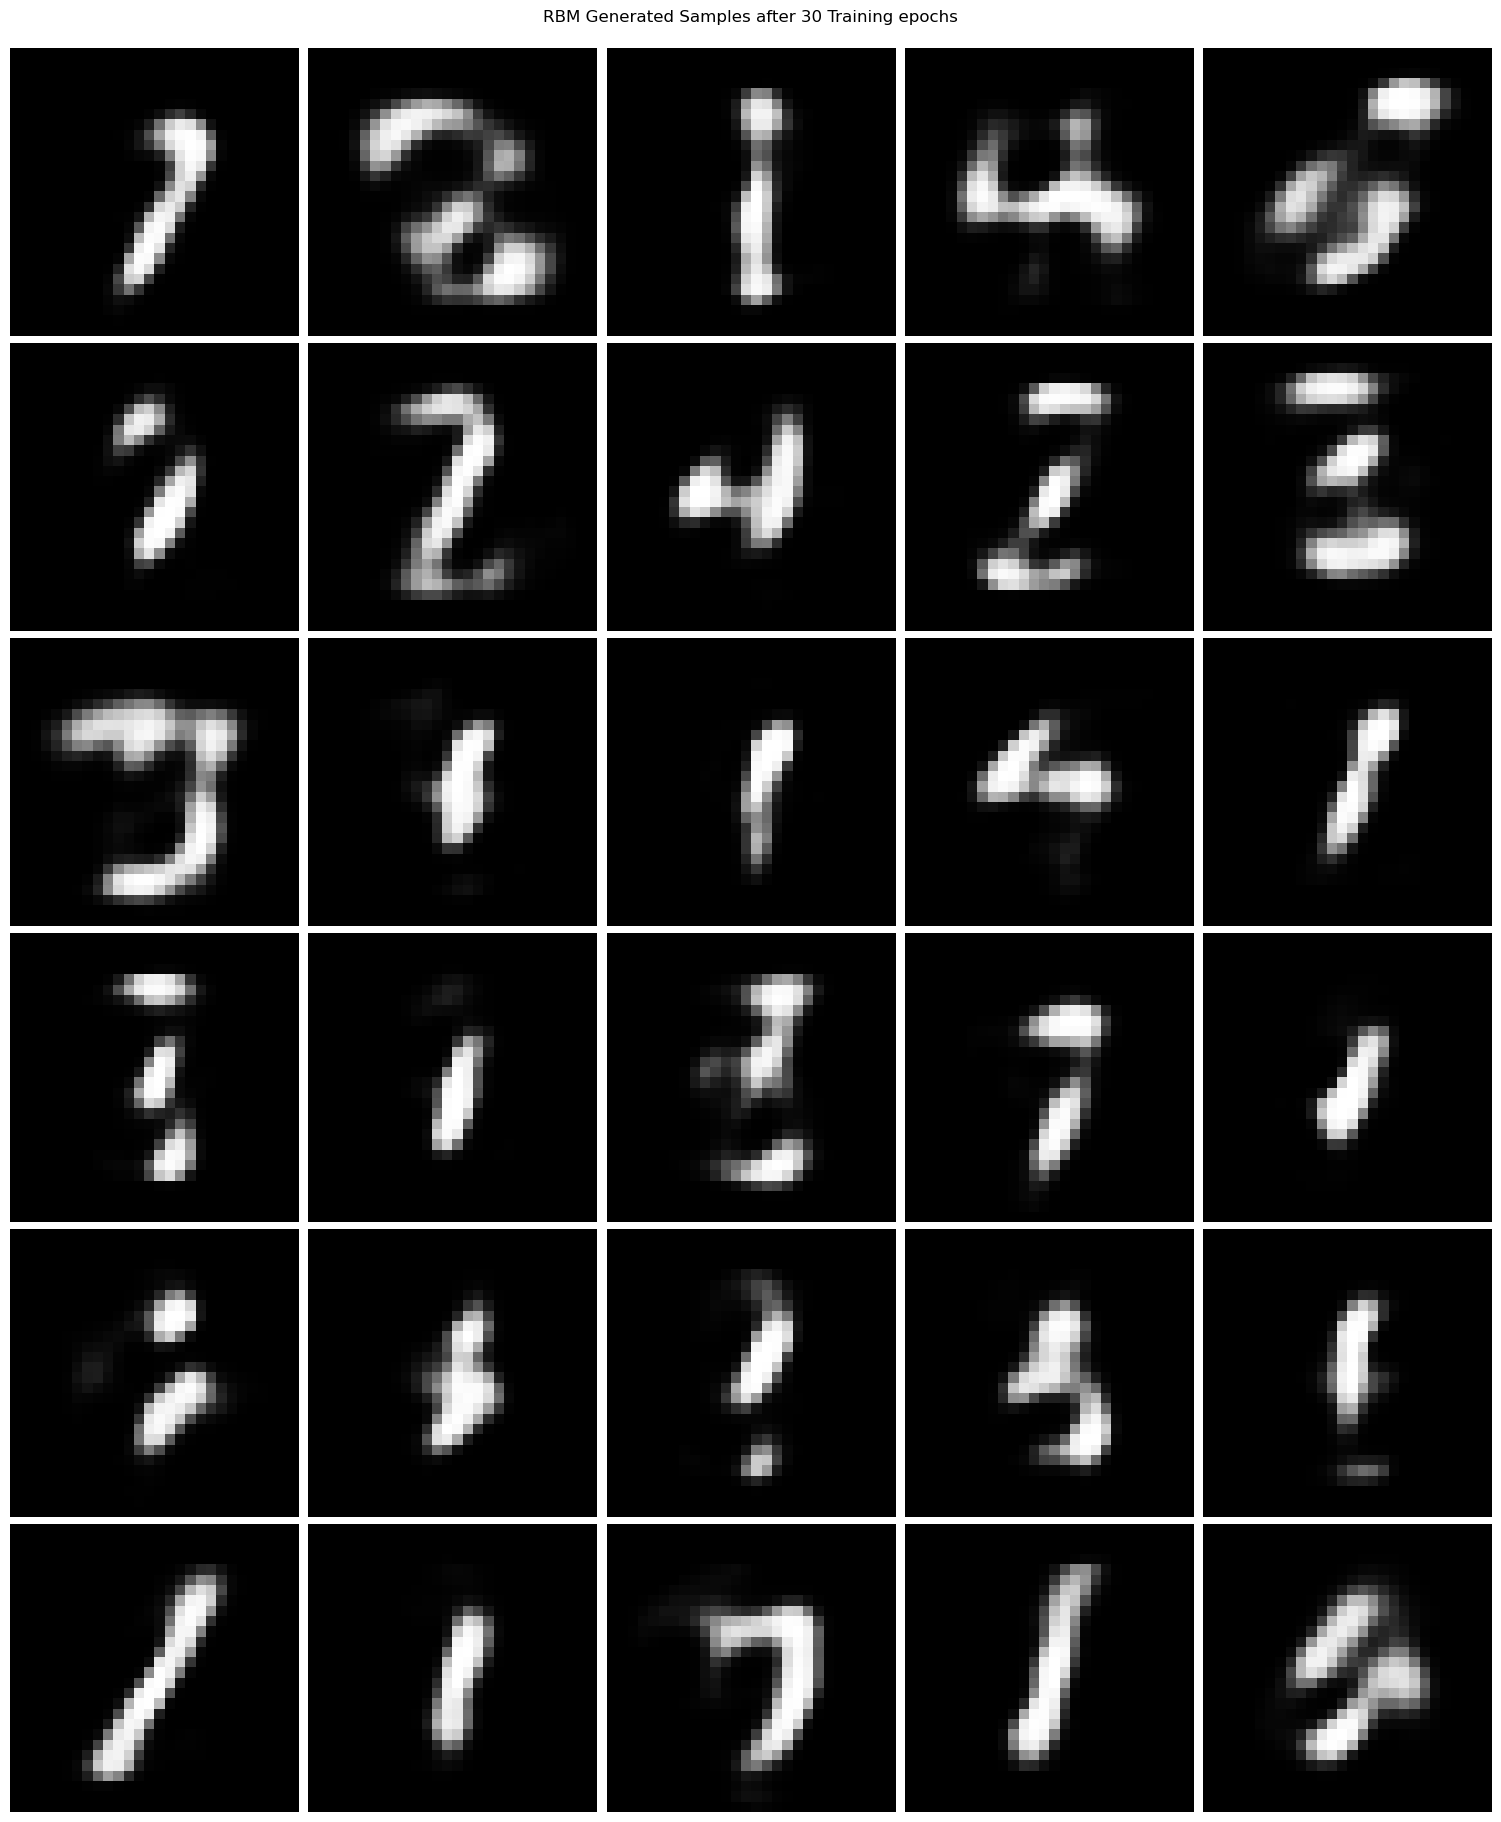

In [11]:
sample(model, num_epochs, num_samples=30, space=0)